## 1. Involved vs Informational - Count of Occurence Analysis

_Ekaterina Levitskaya, Kara Kedrick, and Russell J Funk. "Investigating  writing style as a contributor to gender gaps in science and technology”. In: arXiv (2022). doi: 10.48550/arxiv.2204.13805. eprint: 2204.13805._

Involved features: emphasizing relationships
- pronouns (personal, possessive, wh-pronoun)
- non-phrasal coordination ("and")
- questions

Informational features: emphasizing facts
- determiners (predeterminers, wh-determiers, determiners) --> no stop word removal!
- verbs in past tense
- cardinal numbers

involved rate: (n_pron+n_and+n_q)/N_tokens * 100
informational rate: (n_det+n_pas+n_num)/N_tokens * 100
inv-inf-ratio: involved rate / informational rate

Method:
- segmenting into sentences unsing SaT model (https://arxiv.org/abs/2406.16678) and wtsplit https://github.com/segment-any-text/wtpsplit
- detecting questions using

Concatenating all prompts from on user first, then computing scores.
Otherwise, if computing scores per individual prompt:

    - This approach treats each prompt as an _independent_ observation, but in reality, prompts from the same user are correlated (not independent).
    - The within-user variation gets mixed with between-user variation, increasing "noise" and inflating the standard error.
    - When you aggregate scores _after_ scoring, you're averaging numbers that are already affected by token count normalization and variance-stabilizing effects.
    - When performing statistical tests (like a t-test) at the prompt level, the repeated-measures structure (many prompts per user) is _ignored_, which "dilutes" between-group (gender) differences with within-group variation.
    - This makes it **harder to see a significant difference** — standard errors are larger than they should be, so statistical power is lower.


In [1]:
import sqlite3
import pandas as pd

from helpers.occurences import count_occurrences

conn = sqlite3.connect("../../giicg.db")

prompts = pd.read_sql("Select * from expanded_prompts", conn)
prompts

,message_id,conversation_id,role,message_text,conversational,code,other,gender,user_id,language
0,1,1,user,"parsing data from python iterator, how it coul...","parsing data from python iterator, how it coul...",,,Man (cisgender),6,en
1,730,32,user,Write python function to do operations with in...,Write python function to do operations with in...,,report_dt\tsource\tmetric_name\tmetric_num\tme...,Man (cisgender),6,en
2,1133,55,user,Write shortest tutorial on creating RAG on ema...,Write shortest tutorial on creating RAG on ema...,,,Man (cisgender),6,en
3,1135,55,user,what is FAISS,what is FAISS,,,Man (cisgender),6,en
4,1137,55,user,Transform given code to process large .mbox file,Transform given code to process large .mbox file,,Transform given code to process large .mbox file,Man (cisgender),6,en
...,...,...,...,...,...,...,...,...,...,...
756,1646,82,user,"def run_query(query, n_results):\n query_em...",this is my code. I want to: Get nodes and edge...,"def run_query(query, n_results):\n query_em...",,Man (cisgender),92,en
757,1845,37,user,\n nun möchte ich judgement balancing m...,Now I want to bring judgement balancing into t...,,,Woman (cisgender),29,de
758,1847,37,user,\n ich sehe keine veränderung im Plot. Was ...,I do not see any change in the plot.,,,Woman (cisgender),29,de
759,1849,2,user,\n I am working on the problem of reconstru...,\n I am working on the problem of reconstru...,,Classic CV - Drone navigation\nIf you ever tho...,Man (cisgender),8,en


In [4]:
from helpers.normalization import remove_punctuation_and_newlines, remove_capitalization

prompts['conversational'] = prompts['conversational'].apply(remove_punctuation_and_newlines)
prompts['conversational'] = prompts['conversational'].apply(remove_capitalization)
prompts

,message_id,conversation_id,role,message_text,conversational,code,other,gender,user_id,language
0,1,1,user,"parsing data from python iterator, how it coul...",parsing data from python iterator how it could...,,,Man (cisgender),6,en
1,730,32,user,Write python function to do operations with in...,write python function to do operations with in...,,report_dt\tsource\tmetric_name\tmetric_num\tme...,Man (cisgender),6,en
2,1133,55,user,Write shortest tutorial on creating RAG on ema...,write shortest tutorial on creating rag on ema...,,,Man (cisgender),6,en
3,1135,55,user,what is FAISS,what is faiss,,,Man (cisgender),6,en
4,1137,55,user,Transform given code to process large .mbox file,transform given code to process large mbox file,,Transform given code to process large .mbox file,Man (cisgender),6,en
...,...,...,...,...,...,...,...,...,...,...
756,1646,82,user,"def run_query(query, n_results):\n query_em...",this is my code i want to get nodes and edges ...,"def run_query(query, n_results):\n query_em...",,Man (cisgender),92,en
757,1845,37,user,\n nun möchte ich judgement balancing m...,now i want to bring judgement balancing into t...,,,Woman (cisgender),29,de
758,1847,37,user,\n ich sehe keine veränderung im Plot. Was ...,i do not see any change in the plot,,,Woman (cisgender),29,de
759,1849,2,user,\n I am working on the problem of reconstru...,i am working on the problem of reconstruc...,,Classic CV - Drone navigation\nIf you ever tho...,Man (cisgender),8,en


In [26]:
import spacy
import torch
import re
from wtpsplit import SaT
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from helpers.occurences import count_occurrences


def load_spacy_lanuage_model() -> spacy.language.Language:
    try:
        return spacy.load("en_core_web_sm")
    except OSError:
        print("Downloading missing model...")
        spacy.cli.download("en_core_web_sm")
        return spacy.load("en_core_web_sm")


def load_segmentation_model():
    return SaT("sat-3l-sm")


def load_question_detection_model():
    tokenizer = AutoTokenizer.from_pretrained("mrsinghania/asr-question-detection")
    model = AutoModelForSequenceClassification.from_pretrained("mrsinghania/asr-question-detection")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    print("question model loaded")
    return tokenizer, model, device


def is_question(text: str, tokenizer, model, device) -> bool:
    if not isinstance(text, str) or text.strip() == "":
        return False
    inputs = tokenizer(text, return_tensors="pt", truncation=True).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    predicted_class = torch.argmax(outputs.logits, dim=1).item()
    is_question = predicted_class == 1
    return is_question


def get_pronoun_count(text, spacy_model) -> int:
    doc = spacy_model(text)
    pronouns = [token.text for token in doc if token.pos_ == "PRON"]
    print("prnouns:", pronouns)
    return len(pronouns)


def get_and_count(text: str) -> int:
    matches = re.findall(r'\band\b', text)
    count = len(matches)
    print("and count:", count)
    return count


def get_determiner_count(text, spacy_model) -> int:
    doc = spacy_model(text)
    count = 0
    for token in doc:
        if token.tag_ == "DT":  # Regular determiners (includes "the", "a", "my")
            count += 1
        elif token.tag_ == "PDT":  # Predeterminers (e.g., "all", "such")
            count += 1
        elif token.tag_ == "WDT":  # WH-determiners (e.g., "which", "whatever")
            count += 1
    print("determiner count:", count)
    return count


def get_verb_past_tense_count(text, spacy_model) -> int:
    doc = spacy_model(text)
    count = 0
    for token in doc:
        if token.lower_ == "could":
            continue  # Skip "could"
        if token.tag_ == "VBD" or token.tag_ == "VBN":
            count += 1
    print("verb past tense count:", count)
    return count


def get_number_count(text, spacy_model) -> int:
    doc = spacy_model(text)
    count = 0
    for token in doc:
        if token.pos_ == "NUM": count += 1
    print("number count:", count)
    return count


def get_question_count(text: str, tokenizer, model, device, sat) -> int:
    segmented = sat.split(text)
    count = 0
    for sentence in segmented:
        if is_question(sentence, tokenizer, model, device):
            count += 1
    print("question count:", count)
    return count


def compute_involved(text: str, tokenizer, model, device, sat, spacy_model) -> float:
    print("computing involved score for text: ", text, " ...")
    tokens = spacy_model(text)
    n_pronoun = get_pronoun_count(text, spacy_model)
    print("n_pronoun:", n_pronoun)
    n_and = get_and_count(text)
    print("n_and:", n_and)
    n_question = get_question_count(text, tokenizer, model, device, sat)
    print("n_question:", n_question)
    score = ((n_pronoun + n_and + n_question) / len(tokens)) * 100
    print("involved score:", score)
    return score


def compute_informational(text: str, spacy_model) -> float:
    print("computing informational score for text: ", text, " ...")
    tokens = spacy_model(text)
    n_determiner = get_determiner_count(text, spacy_model)
    n_verb_past_tense = get_verb_past_tense_count(text, spacy_model)
    n_number = get_number_count(text, spacy_model)
    score = ((n_determiner + n_verb_past_tense + n_number) / len(tokens)) * 100
    print("informational score:", score)
    return score


def compute_inv_inf_ratio(inv: float, inf: float) -> float:
    if inf == 0:
        return inv
    return inv / inf

tokenizer, question_model, device = load_question_detection_model()
spacy_model = load_spacy_lanuage_model()
sat = load_segmentation_model()

def compute_scores(prompts, tokenizer, question_model, device, sat, spacy_model):
    prompts['n_tokens'] = prompts['conversational'].apply(lambda x: len(x.split()))

    prompts['n_det'] = prompts.apply(lambda row: (get_determiner_count(row['conversational'], spacy_model)/row['n_tokens'])*100, axis=1)
    prompts['n_past_tense'] = prompts.apply(lambda row: (get_verb_past_tense_count(row['conversational'], spacy_model)/row['n_tokens'])*100, axis=1)
    prompts['n_numbers'] = prompts.apply(lambda row: (get_number_count(row['conversational'], spacy_model)/row['n_tokens'])*100, axis=1)
    prompts['n_pronouns'] = prompts.apply(lambda row: (get_pronoun_count(row['conversational'], spacy_model)/row['n_tokens'])*100, axis=1)
    prompts['n_and'] = prompts.apply(lambda row: (count_occurrences(row['conversational'], "and", True)/row['n_tokens'])*100, axis=1)
    prompts['n_questions'] = prompts.apply(lambda row: (get_question_count(row['conversational'], tokenizer, question_model, device, sat)/row['n_tokens'])*100, axis=1)

    prompts['involved'] = prompts.apply(lambda row: (row['n_pronouns'] + row['n_and'] + row['n_questions']), axis=1)
    prompts['informational'] = prompts.apply(lambda row: (row['n_det'] + row['n_past_tense'] + row['n_numbers']), axis=1)
    prompts['inv_inf'] = prompts.apply(lambda row: compute_inv_inf_ratio(row['involved'], row['informational']) , axis=1)

    return prompts



question model loaded


# Group per user

In [28]:
prompts = compute_scores(prompts, tokenizer, question_model, device, sat, spacy_model)

filtered= prompts[prompts['gender'].isin(['Man (cisgender)', 'Woman (cisgender)'])]
columns = ['involved', 'informational', 'inv_inf', 'n_det', 'n_past_tense', 'n_numbers', 'n_pronouns', 'n_and', 'n_questions']
user_means = (
    filtered.groupby(['user_id', 'gender'])[columns].mean().reset_index()
)
user_means

determiner count: 0
determiner count: 12
determiner count: 0
determiner count: 0
determiner count: 0
determiner count: 1
determiner count: 2
determiner count: 3
determiner count: 1
determiner count: 1
determiner count: 2
determiner count: 3
determiner count: 4
determiner count: 2
determiner count: 3
determiner count: 2
determiner count: 3
determiner count: 1
determiner count: 4
determiner count: 1
determiner count: 0
determiner count: 3
determiner count: 2
determiner count: 4
determiner count: 1
determiner count: 2
determiner count: 3
determiner count: 7
determiner count: 4
determiner count: 8
determiner count: 8
determiner count: 2
determiner count: 1
determiner count: 2
determiner count: 2
determiner count: 1
determiner count: 10
determiner count: 1
determiner count: 1
determiner count: 1
determiner count: 2
determiner count: 4
determiner count: 3
determiner count: 1
determiner count: 3
determiner count: 2
determiner count: 0
determiner count: 2
determiner count: 3
determiner count: 

,user_id,gender,involved,informational,inv_inf,n_det,n_past_tense,n_numbers,n_pronouns,n_and,n_questions
0,6,Man (cisgender),20.590146,11.742204,8.531987,8.680352,2.552168,0.509684,11.943360,0.617284,8.029501
1,8,Man (cisgender),8.193980,18.060201,0.500000,14.214047,0.000000,3.846154,8.193980,0.000000,0.000000
2,11,Woman (cisgender),21.382256,19.278544,1.317100,15.102779,1.549103,2.626662,14.699151,0.570248,6.112857
3,15,Man (cisgender),15.664488,13.921569,4.203704,13.921569,0.000000,0.000000,15.664488,0.000000,0.000000
4,16,Woman (cisgender),15.110395,16.448038,0.921974,13.557609,1.533469,1.356959,10.717149,1.319450,3.073796
5,25,Man (cisgender),14.791667,15.625000,0.950000,14.301471,1.323529,0.000000,7.058824,2.303922,5.428922
6,28,Woman (cisgender),18.801711,18.568637,1.099297,16.080422,2.025163,0.463052,14.888285,2.045935,1.867491
7,29,Woman (cisgender),10.457516,20.915033,0.500000,17.973856,1.960784,0.980392,6.535948,3.921569,0.000000
8,31,Man (cisgender),20.060606,24.636364,0.861111,16.727273,7.353535,0.555556,10.686869,0.909091,8.464646
9,34,Man (cisgender),13.577383,19.063797,3.777699,13.992177,3.487476,1.584144,9.528281,1.342268,2.706835


## plot

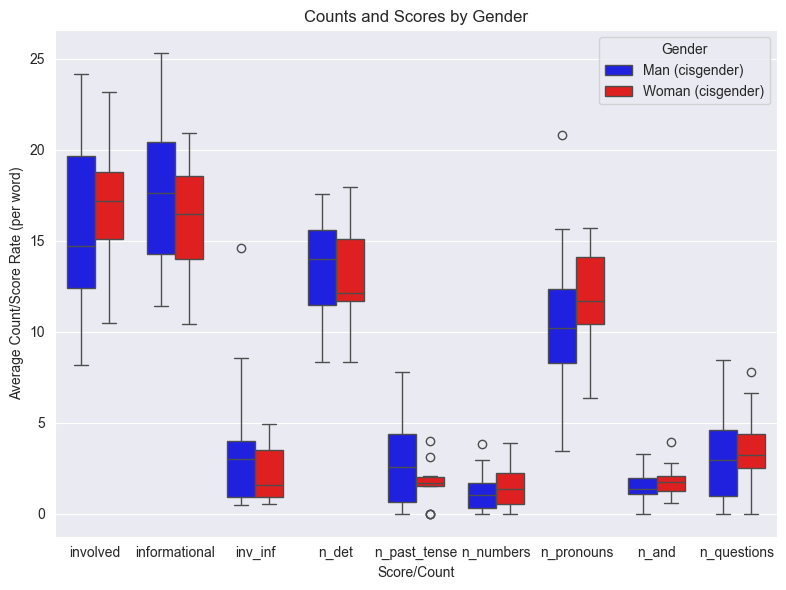

involved:
  T-statistic: -0.9893, p-value: 0.3317
  Female: n=13, variance=12.6476
  Male:   n=15, variance=20.1034
informational:
  T-statistic: 0.9339, p-value: 0.3592
  Female: n=13, variance=10.0319
  Male:   n=15, variance=18.4386
inv_inf:
  T-statistic: 1.1820, p-value: 0.2515
  Female: n=13, variance=2.4607
  Male:   n=15, variance=14.0264
n_det:
  T-statistic: 0.4195, p-value: 0.6783
  Female: n=13, variance=8.0553
  Male:   n=15, variance=9.2001
n_past_tense:
  T-statistic: 1.6223, p-value: 0.1207
  Female: n=13, variance=1.3488
  Male:   n=15, variance=7.1553
n_numbers:
  T-statistic: -0.8743, p-value: 0.3903
  Female: n=13, variance=1.3731
  Male:   n=15, variance=1.2671
n_pronouns:
  T-statistic: -0.5001, p-value: 0.6213
  Female: n=13, variance=10.3306
  Male:   n=15, variance=17.6956
n_and:
  T-statistic: -0.9656, p-value: 0.3434
  Female: n=13, variance=0.8351
  Male:   n=15, variance=0.8036
n_questions:
  T-statistic: -0.5089, p-value: 0.6151
  Female: n=13, variance=4.

In [29]:
from helpers.stats import run_t_test_on_gender
import matplotlib.pyplot as plt
import seaborn as sns

# "Melt" the DataFrame for seaborn
melted = user_means.melt(
    id_vars=['user_id', 'gender'],
    value_vars=columns,
    var_name='Score/Count',
    value_name='Normalized Rate'
)

plt.figure(figsize=(8,6))
sns.boxplot(
    data=melted,
    x='Score/Count',
    y='Normalized Rate',
    hue='gender',
    palette={'Woman (cisgender)': 'red', 'Man (cisgender)': 'blue'},
    width=0.7
)

plt.title('Counts and Scores by Gender')
plt.ylabel('Average Count/Score Rate (per word)')
plt.xlabel('Score/Count')
plt.legend(title='Gender')
plt.tight_layout()
plt.show()

for col in columns:
    run_t_test_on_gender(user_means, col)



## Concatenate per user first

determiner count: 19
determiner count: 5
determiner count: 25
determiner count: 5
determiner count: 75
determiner count: 15
determiner count: 90
determiner count: 9
determiner count: 15
determiner count: 195
determiner count: 11
determiner count: 132
determiner count: 26
determiner count: 91
determiner count: 14
determiner count: 10
determiner count: 4
determiner count: 10
determiner count: 396
determiner count: 55
determiner count: 104
determiner count: 25
determiner count: 43
determiner count: 8
determiner count: 51
determiner count: 33
determiner count: 167
determiner count: 22
verb past tense count: 7
verb past tense count: 0
verb past tense count: 3
verb past tense count: 0
verb past tense count: 12
verb past tense count: 2
verb past tense count: 13
verb past tense count: 2
verb past tense count: 5
verb past tense count: 41
verb past tense count: 4
verb past tense count: 27
verb past tense count: 0
verb past tense count: 27
verb past tense count: 5
verb past tense count: 0
verb pa

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


prnouns: ['i', 'i', 'i', 'them', 'that', 'it', 'that', 'it', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'there', 'it', 'i', 'it', 'what', 'there', 'it', 'i', 'me', 'all', 'i', 'this', 'i', 'there', 'i', 'i', 'i', 'it', 'its', 'we', 'i', 'there', 'there', 'it', 'i', 'you', 'them', 'which', 'i', 'i', 'it', 'us', 'it', 'you', 'no', 'us', 'me', 'it', 'us', 'it', 'i', 'it', 'that', 'there', 'i', 'you', 'it', 'it', 'me', 'i', 'them', 'i', 'i', 'which', 'he', 'it', 'us', 'this', 'we', 'it', 'we', 'us', 'i', 'i', 'i', 'you', 'i', 'both', 'it', 'it', 'i', 'i', 'i', 'anything', 'i', 'i', 'they', 'i', 'them', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'you', 'what', 'i', 'i', 'it', 'i', 'that', 'i', 'it', 'they', 'i', 'it', 'this', 'i', 'i', 'it', 'i', 'it', 'i']
prnouns: ['my', 'my', 'i', 'i', 'me', 'i', 'all', 'it', 'i', 'this', 'my', 'i', 'everything', 'i', 'there', 'that']
question count: 3
question count: 0
question count: 9
question count: 0
question count: 13
question count: 2
question count: 12
question 

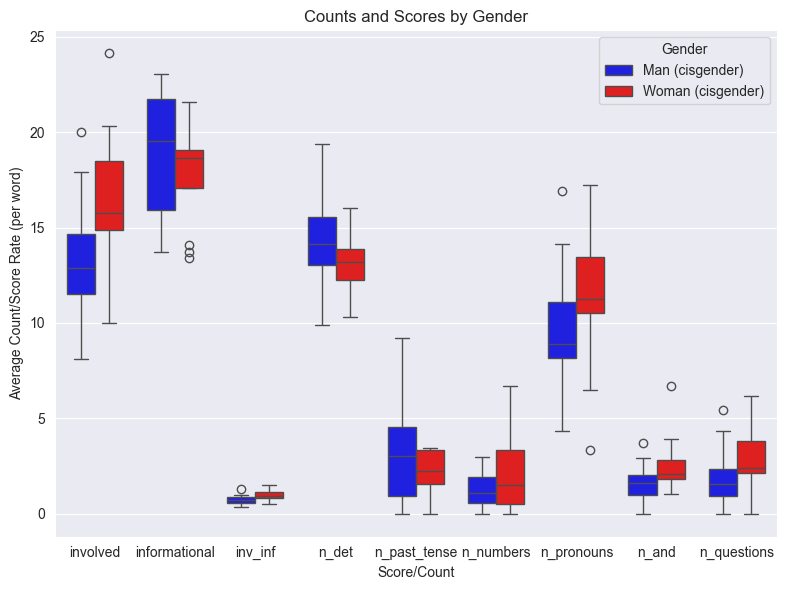

involved:
  T-statistic: -2.4532, p-value: 0.0217
  Female: n=13, variance=13.8020
  Male:   n=15, variance=10.7534
informational:
  T-statistic: 0.9167, p-value: 0.3679
  Female: n=13, variance=6.4930
  Male:   n=15, variance=12.2204
inv_inf:
  T-statistic: -2.2785, p-value: 0.0325
  Female: n=13, variance=0.0893
  Male:   n=15, variance=0.0541
n_det:
  T-statistic: 1.4581, p-value: 0.1575
  Female: n=13, variance=2.8103
  Male:   n=15, variance=6.2024
n_past_tense:
  T-statistic: 1.2305, p-value: 0.2320
  Female: n=13, variance=1.7247
  Male:   n=15, variance=6.8922
n_numbers:
  T-statistic: -1.5473, p-value: 0.1413
  Female: n=13, variance=5.1486
  Male:   n=15, variance=1.0068
n_pronouns:
  T-statistic: -0.8876, p-value: 0.3835
  Female: n=13, variance=13.0506
  Male:   n=15, variance=10.2262
n_and:
  T-statistic: -2.0062, p-value: 0.0580
  Female: n=13, variance=2.1850
  Male:   n=15, variance=1.0398
n_questions:
  T-statistic: -1.8804, p-value: 0.0717
  Female: n=13, variance=2.6

In [27]:
user_prompts = (
    prompts.groupby(['user_id', 'gender'])['conversational']
    .apply(' '.join)
    .reset_index()
)

user_prompts= user_prompts[user_prompts['gender'].isin(['Man (cisgender)', 'Woman (cisgender)'])]

user_prompts = compute_scores(user_prompts, tokenizer, question_model, device, sat, spacy_model)

melted = user_prompts.melt(
    id_vars=['user_id', 'gender'],
    value_vars=columns,
    var_name='Score/Count',
    value_name='Normalized Rate'
)

plt.figure(figsize=(8,6))
sns.boxplot(
    data=melted,
    x='Score/Count',
    y='Normalized Rate',
    hue='gender',
    palette={'Woman (cisgender)': 'red', 'Man (cisgender)': 'blue'},
    width=0.7
)

plt.title('Counts and Scores by Gender')
plt.ylabel('Average Count/Score Rate (per word)')
plt.xlabel('Score/Count')
plt.legend(title='Gender')
plt.tight_layout()
plt.show()

for col in columns:
    run_t_test_on_gender(user_prompts, col)


In [30]:
user_prompts

,user_id,gender,conversational,n_tokens,n_det,n_past_tense,n_numbers,n_pronouns,n_and,n_questions,involved,informational,inv_inf
0,6,Man (cisgender),parsing data from python iterator how it could...,192,9.895833,3.645833,2.604167,9.375000,0.520833,1.562500,11.458333,16.145833,0.709677
1,8,Man (cisgender),i am working on the problem of reconstruc...,36,13.888889,0.000000,2.777778,8.333333,0.000000,0.000000,8.333333,16.666667,0.500000
2,11,Woman (cisgender),can you adapt the following code so that inste...,193,12.953368,1.554404,4.145078,13.471503,1.036269,4.663212,19.170984,18.652850,1.027778
3,15,Man (cisgender),setalltables action is currently not fetching ...,36,13.888889,0.000000,0.000000,13.888889,0.000000,0.000000,13.888889,13.888889,1.000000
4,16,Woman (cisgender),i want to use dummy hot encoding to replace th...,541,13.863216,2.218115,1.293900,11.275416,1.293900,2.402957,14.972274,17.375231,0.861702
5,25,Man (cisgender),what is the best way to encode and compress a ...,106,14.150943,1.886792,0.000000,10.377358,1.886792,1.886792,14.150943,16.037736,0.882353
6,28,Woman (cisgender),i have a pandas dataframe like this i want to...,562,16.014235,2.313167,0.711744,13.523132,2.313167,2.135231,17.971530,19.039146,0.943925
7,29,Woman (cisgender),now i want to bring judgement balancing into t...,60,15.000000,3.333333,1.666667,3.333333,6.666667,0.000000,10.000000,20.000000,0.500000
9,31,Man (cisgender),how can i make use of an observablehqdatabasec...,92,16.304348,5.434783,1.086957,8.695652,1.086957,5.434783,15.217391,22.826087,0.666667
10,34,Man (cisgender),blender and python i have a collection of hund...,1299,15.011547,3.156274,2.001540,8.006159,1.616628,1.385681,11.008468,20.169361,0.545802
